In [147]:
!pip install torch torchvision torchaudio
!pip install scikit-learn

In [148]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

debug = 0

In [160]:
df = pd.read_csv('.vscode/AI2100/mental-health-model/train.csv') # path to the training csv
if debug:
    print(df)

In [161]:
# Split data into train, test, validation sets
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)/len(df)*100:.2f}%")
print(f"Test: {len(test_data)/len(df)*100:.2f}%")
print(f"Validation: {len(val_data)/len(df)*100:.2f}%")

Train: 60.00%
Test: 20.00%
Validation: 20.00%


In [162]:
# Getting the feature subset from the dataset
features = ["Gender", "Age", "Working Professional or Student", "Academic Pressure", "Work Pressure",
            "Study Satisfaction", "Job Satisfaction", "Sleep Duration", "Dietary Habits", 
            "Have you ever had suicidal thoughts ?", "Work/Study Hours", "Financial Stress",
            "Family History of Mental Illness"]
# Sets initial value so it can run. Changed when trying to make it modular.
feature_df = df.copy()

In [163]:
# Normalizing features using min-max normalization (x-min)/(max-min)
def mm_normalization(column_name, df):
    feature_max = df[column_name].max()
    feature_min = df[column_name].min()
    df[column_name] = (df[column_name] - feature_min) / (feature_max - feature_min)

In [164]:
def data_prep(df):
    feature_df = df[features].copy()
    feature_df.loc[:,"Work Pressure"] = df["Work Pressure"].fillna(df["Academic Pressure"])
    feature_df.loc[:,"Job Satisfaction"] = df["Job Satisfaction"].fillna(df["Study Satisfaction"])
    feature_df = feature_df.drop(columns=["Academic Pressure", "Study Satisfaction"])
    
    # Calling the min-max normalization function
    mm_normalization("Age", feature_df)
    mm_normalization("Work Pressure", feature_df)
    mm_normalization("Job Satisfaction", feature_df)
    mm_normalization("Work/Study Hours", feature_df)
    mm_normalization("Financial Stress", feature_df)
    if debug:
        print(feature_df)
        print(feature_df.columns.tolist())

    # label encoding for binary features
    label_encoder = preprocessing.LabelEncoder() 

    feature_df['Gender']= label_encoder.fit_transform(feature_df['Gender'])
    feature_df['Working Professional or Student']= label_encoder.fit_transform(feature_df['Working Professional or Student'])
    feature_df['Have you ever had suicidal thoughts ?']= label_encoder.fit_transform(feature_df['Have you ever had suicidal thoughts ?'])
    feature_df['Family History of Mental Illness']= label_encoder.fit_transform(feature_df['Family History of Mental Illness'])
    feature_df['Gender']= label_encoder.fit_transform(feature_df['Gender'])
    if debug:
        print(feature_df["Working Professional or Student"].unique())
        print(feature_df)


    # Preparing the data for one-hot encoding
    # Mapping 'Sleep Duration' values that aren't in the standard format to their correct range
    sleep_map = {
        'More than 8 hours': 'More than 8 hours',
        'Less than 5 hours': 'Less than 5 hours',
        '5-6 hours': '5-6 hours',
        '7-8 hours': '7-8 hours',
        '6-8 hours': '7-8 hours',
        '6-7 hours': '7-8 hours',
        '8 hours': '7-8 hours',
        '9-11 hours': 'More than 8 hours',
        '10-11 hours': 'More than 8 hours',
        '40-45 hours': 'More than 8 hours',
        '9-6 hours': '7-8 hours',
        '1-2 hours': 'Less than 5 hours',
        '2-3 hours': 'Less than 5 hours',
        '3-4 hours': 'Less than 5 hours',
        '1-3 hours': 'Less than 5 hours',
        '1-6 hours': 'Less than 5 hours',
        'Unhealthy': 'Other',
        'Work_Study_Hours': 'Other',
        'Moderate': 'Other',
        'Indore': 'Other',
        'Pune': 'Other',
        'than 5 hours': 'Less than 5 hours',
        '55-66 hours': 'More than 8 hours',
        '45-48 hours': 'More than 8 hours',
        '45': 'More than 8 hours',
        '49 hours': 'More than 8 hours',
        'No': 'Other',
        '10-6 hours': 'More than 8 hours',
        '9-5 hours': '7-8 hours',
        'Other': 'Other',
        'Sleep_Duration': 'Other',
    }
    # Changing the values in the dataframe
    feature_df['Sleep Duration'] = feature_df['Sleep Duration'].map(sleep_map)
    feature_df['Sleep Duration'] = feature_df['Sleep Duration'].fillna('Other')
    if debug:
        print(feature_df['Sleep Duration'].unique())


    # More prep for one-hot encoding
    # Mapping 'Dietary Habits' values that aren't in the standard format to their correct range
    diet_map = {
        'Moderate': 'Moderate',
        'Unhealthy': 'Unhealthy',
        'Healthy': 'Healthy',
        'Yes': 'Other',
        'No': 'Other',
        'More Healthy': 'Healthy',
        'No Healthy': 'Unhealthy',
        'Class 12': 'Other',
        'Indoor': 'Other',
        'Male': 'Other',
        'Vegas': 'Other',
        'M.Tech': 'Other',
        'Less Healthy': 'Unhealthy',
        '1': 'Other',
        'Electrician': 'Other',
        'Hormonal': 'Other',
        'Mihir': 'Other',
        'Less than Healthy': 'Unhealthy',
        '3': 'Other',
        'Gender': 'Other',
        'BSc': 'Other',
        'Pratham': 'Other',
        '2': 'Other',
    }
    # Changing the values in the dataframe
    feature_df['Dietary Habits'] = feature_df['Dietary Habits'].map(diet_map)
    feature_df['Dietary Habits'] = feature_df['Dietary Habits'].fillna('Other')
    if debug:
        print(feature_df['Dietary Habits'].unique())
        print(feature_df)

    # One-hot encoding for remaining features
    encoder = preprocessing.OneHotEncoder(sparse_output=False)
    feature_list = ['Sleep Duration', 'Dietary Habits']
    encoded_data = encoder.fit_transform(feature_df[feature_list])

    # Convert encoded data to a dataframe with aligned index for training set
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(feature_list), index=feature_df.index)

    # Concatenate the encoded data with the original dataframe
    tmp_df = pd.concat([feature_df, encoded_df], axis=1)

    # Drop the original columns from the dataframe
    feature_df = tmp_df.drop(columns=feature_list, axis=1)

    if debug:
        print(feature_df.columns.tolist())

    # Combine into input vector and removing NaN values
    nan_features = feature_df.columns[feature_df.isna().any()].tolist()
    feature_df[nan_features] = feature_df[nan_features].fillna(0.5)
    if debug:
        print(feature_df.isnull().any())

    input_vector = feature_df.to_numpy()
    if debug:
        unique_values, counts = np.unique(input_vector, return_counts=True)
        print(unique_values)
        print(counts)
    
    return input_vector

input_vector = data_prep(train_data)
print(np.unique(input_vector))

[0.         0.02380952 0.04761905 0.07142857 0.08333333 0.0952381
 0.11904762 0.14285714 0.16666667 0.19047619 0.21428571 0.23809524
 0.25       0.26190476 0.28571429 0.30952381 0.33333333 0.35714286
 0.38095238 0.4047619  0.41666667 0.42857143 0.45238095 0.47619048
 0.5        0.52380952 0.54761905 0.57142857 0.58333333 0.5952381
 0.61904762 0.64285714 0.66666667 0.69047619 0.71428571 0.73809524
 0.75       0.76190476 0.78571429 0.80952381 0.83333333 0.85714286
 0.88095238 0.9047619  0.91666667 0.92857143 0.95238095 0.97619048
 1.        ]


In [178]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [184]:
# Put into tensors and get the ground truth for the aligned indecies
train = input_vector.copy()
train = torch.FloatTensor(train)

y_train = train_data['Depression']
y_train = torch.LongTensor(y_train.to_numpy())

input_size = train.shape[1]
hidden_size = 64
num_classes = len(torch.unique(y_train))

model = MLP(input_size, hidden_size, num_classes, 0.5) # Can change the dropout_rate here too

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 500
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        


Epoch [10/500], Loss: 0.5714
Epoch [20/500], Loss: 0.5003
Epoch [30/500], Loss: 0.4620
Epoch [40/500], Loss: 0.4388
Epoch [50/500], Loss: 0.4158
Epoch [60/500], Loss: 0.3898
Epoch [70/500], Loss: 0.3623
Epoch [80/500], Loss: 0.3335
Epoch [90/500], Loss: 0.3062
Epoch [100/500], Loss: 0.2834
Epoch [110/500], Loss: 0.2639
Epoch [120/500], Loss: 0.2473
Epoch [130/500], Loss: 0.2362
Epoch [140/500], Loss: 0.2262
Epoch [150/500], Loss: 0.2176
Epoch [160/500], Loss: 0.2134
Epoch [170/500], Loss: 0.2076
Epoch [180/500], Loss: 0.2031
Epoch [190/500], Loss: 0.1999
Epoch [200/500], Loss: 0.1975
Epoch [210/500], Loss: 0.1965
Epoch [220/500], Loss: 0.1915
Epoch [230/500], Loss: 0.1908
Epoch [240/500], Loss: 0.1892
Epoch [250/500], Loss: 0.1873
Epoch [260/500], Loss: 0.1847
Epoch [270/500], Loss: 0.1846
Epoch [280/500], Loss: 0.1824
Epoch [290/500], Loss: 0.1809
Epoch [300/500], Loss: 0.1805
Epoch [310/500], Loss: 0.1801
Epoch [320/500], Loss: 0.1780
Epoch [330/500], Loss: 0.1773
Epoch [340/500], Lo

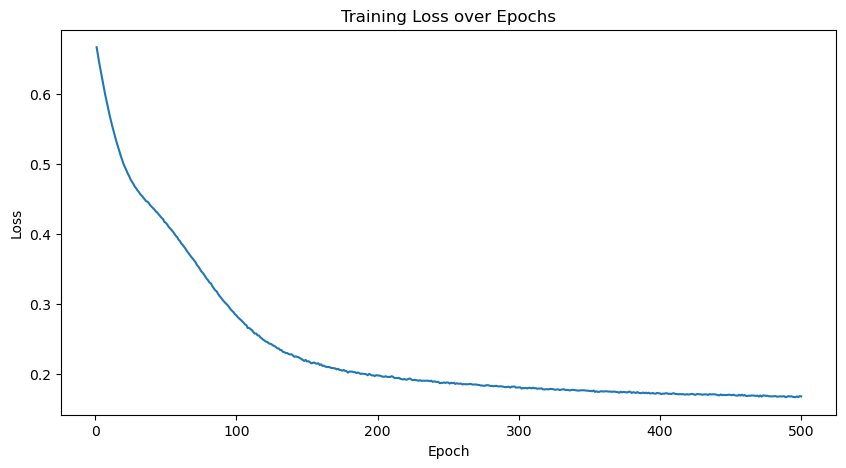

In [185]:
# Draw the figure of loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [186]:
# Prep test data
test_vector = data_prep(test_data)
test = test_vector.copy()
test = torch.FloatTensor(test)

y_test = test_data['Depression']
y_test = torch.LongTensor(y_test.to_numpy())

In [187]:
# Evaluate the model
with torch.no_grad():
    outputs = model(test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9339


In [188]:
# Showing the imbalance in the data
from sklearn.metrics import classification_report

y_true = y_test.numpy()
y_pred = predicted.numpy()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     22999
           1       0.84      0.80      0.81      5141

    accuracy                           0.93     28140
   macro avg       0.90      0.88      0.89     28140
weighted avg       0.93      0.93      0.93     28140

